In [1]:
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    AncillaRegister,
    IBMQ,
    Aer,
    __qiskit_version__,
)
from qiskit.circuit.library import QFT, GraphState, GroverOperator
from qiskit.qasm import pi
from qiskit_nature.drivers import Molecule

import numpy as np
import matplotlib.pyplot as plt
import os.path
import time

from src.utils import *
from src.benchmarks import (
    grover,
    qaoa,
    ghz,
    qft,
    qftentangled,
    shor,
    wstate,
    qpeinexact,
    qpeexact,
    graphstate,
    vqe,
    dj,
    hhl,
    ae,
    qwalk,
)
from src.benchmarks.qiskit_application_optimization import routing, tsp
from src.benchmarks.qiskit_application_finance import (
    portfolioqaoa,
    portfoliovqe,
    pricingcall,
    pricingput,
)
from src.benchmarks.qiskit_application_ml import qgan
from src.benchmarks.qiskit_application_nature import groundstate, excitedstate
import json
import importlib
import random
import numpy
from matplotlib import pyplot
import signal

# New Structure of Generator

In [2]:
def create_benchmarks_from_config(cfg=None):
    characteristics = []

    if not cfg:
        with open("config.json", "r") as jsonfile:
            cfg = json.load(jsonfile)
            print("Read config successful")

    # global seetings
    global save_png
    save_png = cfg["save_png"]
    global save_hist
    save_hist = cfg["save_hist"]
    global max_depth
    max_depth = cfg["max_depth"]
    global timeout
    timeout = cfg["timeout"]

    for benchmark in cfg["benchmarks"]:
        print(benchmark["name"])  #
        characteristics.extend(generate_benchmark(benchmark))
    return characteristics

In [3]:
def benchmark_generation_watcher(func, args):
    class TimeoutException(Exception):  # Custom exception class
        pass

    def timeout_handler(signum, frame):  # Custom signal handler
        raise TimeoutException

    # Change the behavior of SIGALRM
    signal.signal(signal.SIGALRM, timeout_handler)

    signal.alarm(timeout)
    try:
        filename, depth, num_qubits = func(*args)
    except TimeoutException:
        print("Calculation/Generation exceeded timeout limit for ", func, args[1:])
        return False
    else:
        # Reset the alarm
        signal.alarm(0)

    if depth > max_depth:
        print("Depth of generated circuit is too large: ", depth)
        return False

    return filename, depth, num_qubits

In [4]:
def qc_creation_watcher(func, args):
    class TimeoutException(Exception):  # Custom exception class
        pass

    def timeout_handler(signum, frame):  # Custom signal handler
        raise TimeoutException

    # Change the behavior of SIGALRM
    signal.signal(signal.SIGALRM, timeout_handler)

    signal.alarm(timeout)
    try:
        qc, num_qubits, file_precheck = func(*args)
    except TimeoutException:
        print("Calculation/Generation exceeded timeout limit for ", func, args[1:])
        return False
    except:
        print("Something else went wrong :(")
        return False
    else:
        # Reset the alarm
        signal.alarm(0)

    return qc, num_qubits, file_precheck

In [5]:
def generate_benchmark(benchmark):
    characteristics = []
    if benchmark["include"]:
        if benchmark["creation_function_identifier"] == 0:
            for n in range(
                benchmark["min_qubits"], benchmark["max_qubits"], benchmark["stepsize"]
            ):

                # res_qc_creation = qc, num_qubits, file_precheck
                # res = filename, depth, num_qubits
                res_qc_creation = qc_creation_watcher(create_scalable_qc, [benchmark, n])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 1:
            for anc_mode in benchmark["ancillary_mode"]:
                for n in range(
                    benchmark["min_qubits"], benchmark["max_qubits"], benchmark["stepsize"]
                ):
                    res_qc_creation = qc_creation_watcher(
                        create_scalable_qc, [benchmark, n, anc_mode]
                    )
                    if not res_qc_creation:
                        break
                    res = generate_circuits_on_all_layer(*res_qc_creation)
                    if len(res) == 0:
                        break
                    characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 2:
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_shor_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 3:
            for i in range(benchmark["min_index"], benchmark["max_index"]):
                res_qc_creation = qc_creation_watcher(create_hhl_qc, [i])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)
                break

        elif benchmark["creation_function_identifier"] == 4:
            for nodes in range(benchmark["min_nodes"], benchmark["max_nodes"]):
                res_qc_creation = qc_creation_watcher(create_routing_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 5:
            for nodes in range(benchmark["min_nodes"], benchmark["max_nodes"]):
                res_qc_creation = qc_creation_watcher(create_tsp_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 6:
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_groundstate_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 7:
            for choice in benchmark["instances"]:
                res_qc_creation = qc_creation_watcher(create_excitedstate_qc, [choice])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 8:
            for nodes in range(benchmark["min_uncertainty"], benchmark["max_uncertainty"]):
                res_qc_creation = qc_creation_watcher(create_pricingcall_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

        elif benchmark["creation_function_identifier"] == 9:
            for nodes in range(benchmark["min_uncertainty"], benchmark["max_uncertainty"]):
                res_qc_creation = qc_creation_watcher(create_pricingput_qc, [nodes])
                if not res_qc_creation:
                    break
                res = generate_circuits_on_all_layer(*res_qc_creation)
                if len(res) == 0:
                    break
                characteristics.extend(res)

    return characteristics

In [6]:
def generate_circuits_on_all_layer(qc, num_qubits, file_precheck):
    characteristics = []
    # filename_algo, depth = generate_algo_layer_circuit(qc, n, save_png, save_hist)
    # characteristics.append([filename_algo, n, depth])

    res_t_indep = generate_target_indep_layer_circuit(
        qc, num_qubits, save_png, save_hist, file_precheck
    )

    if res_t_indep:
        characteristics.extend(res_t_indep)
    else:
        return characteristics

    res_t_dep = generate_target_dep_layer_circuit(
        qc, num_qubits, save_png, save_hist, file_precheck
    )

    if res_t_dep:
        characteristics.extend(res_t_dep)
    else:
        return characteristics

    return characteristics

In [7]:
def generate_algo_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist
):
    characteristics = []
    res = benchmark_generation_watcher(
        handle_algorithm_layer, [qc, num_qubits, save_png, save_hist]
    )
    characteristics.append(res)

    if res:
        characteristics.append(res)
        return characteristics
    else:
        return False

In [8]:
def generate_target_indep_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist, file_precheck
):
    characteristics = []
    res = benchmark_generation_watcher(
        get_indep_layer, [qc, num_qubits, save_png, save_hist, file_precheck]
    )
    if res:
        characteristics.append(res)
        return characteristics
    else:
        return False

In [9]:
def generate_target_dep_layer_circuit(
    qc: QuantumCircuit, num_qubits: int, save_png, save_hist, file_precheck
):
    characteristics = []

    ibm_native_gates = FakeMontreal().configuration().basis_gates
    rigetti_native_gates = ["rx", "rz", "cz"]
    gate_sets = [(ibm_native_gates, "ibm"), (rigetti_native_gates, "rigetti")]

    for gate_set, gate_set_name in gate_sets:
        try:
            for opt_level in range(4):

                # Creating the circuit on target-dependent: native gates layer

                res = benchmark_generation_watcher(
                    get_native_gates_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        num_qubits,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )
                if res:
                    characteristics.append(res)
                else:
                    break
                n_actual = res[2]

                # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                res = benchmark_generation_watcher(
                    get_mapped_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        n_actual,
                        True,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )

                if res:
                    characteristics.append(res)
                else:
                    break
                res = benchmark_generation_watcher(
                    get_mapped_layer,
                    [
                        qc,
                        gate_set,
                        gate_set_name,
                        opt_level,
                        n_actual,
                        False,
                        save_png,
                        save_hist,
                        file_precheck,
                    ],
                )

                if res:
                    characteristics.append(res)
                else:
                    break
        except Exception as e:
            print(
                "\n Problem occured in inner loop: ",
                qc.name,
                num_qubits,
                gate_set_name,
                e,
            )

    return characteristics

In [10]:
def create_scalable_qc(benchmark, num_qubits, ancillary_mode=None):
    file_precheck = True
    try:
        # Creating the circuit on Algorithmic Description Layer
        lib = importlib.import_module(benchmark["module_path"])
        if benchmark["name"] == "grover" or benchmark["name"] == "qwalk":
            qc = lib.create_circuit(num_qubits, ancillary_mode=ancillary_mode)
            qc.name = qc.name + "-" + ancillary_mode
            file_precheck = False

        else:
            qc = lib.create_circuit(num_qubits)

        n = qc.num_qubits
        return qc, n, file_precheck

    except Exception as e:
        print("\n Problem occured in outer loop: ", benchmark, num_qubits, e)

In [11]:
def create_shor_qc(choice: str):
    instances = {
        "xsmall": [9, 4],
        "small": [15, 4],
        "medium": [821, 4],
        "large": [11777, 4],
        "xlarge": [201209, 4],
    }
    small = [15, 4]  # 18 qubits
    medium = [821, 4]  # 42 qubits
    large = [11777, 4]  # 58 qubits
    xlarge = [201209, 4]  # 74 qubits

    try:
        qc = shor.create_circuit(instances[choice][0], instances[choice][1])
        return qc, qc.num_qubits, False

    except Exception as e:
        print("\n Problem occured in outer loop: ", "create_shor_benchmarks: ", choice)

In [12]:
def create_hhl_qc(index: int):
    # index is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = hhl.create_circuit(index)
        return qc, qc.num_qubits, False

    except Exception as e:
        print("\n Problem occured in outer loop: ", "create_hhl_benchmarks", index, e)

In [13]:
def create_routing_qc(nodes: int):
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = routing.create_circuit(nodes, 2)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ", "create_routing_benchmarks", nodes, e
        )

In [14]:
def create_tsp_qc(nodes: int):
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = tsp.create_circuit(nodes)
        return qc, qc.num_qubits, False

    except Exception as e:
        print("\n Problem occured in outer loop: ", "create_tsp_benchmarks", nodes, e)

In [15]:
def create_groundstate_qc(choice: str):

    m_1 = Molecule(
        geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]],
        charge=0,
        multiplicity=1,
    )
    m_2 = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]],
        charge=0,
        multiplicity=1,
    )
    m_3 = Molecule(
        geometry=[
            ["O", [0.0, 0.0, 0.0]],
            ["H", [0.586, 0.757, 0.0]],
            ["H", [0.586, -0.757, 0.0]],
        ],
        charge=0,
        multiplicity=1,
    )

    instances = {"small": m_1, "medium": m_2, "large": m_3}

    try:
        qc = groundstate.create_circuit(instances[choice])
        qc.name = qc.name + "-" + choice
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_groundstate_benchmarks",
            choice,
            e,
        )

In [16]:
def create_excitedstate_qc(choice: str):

    m_1 = Molecule(
        geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]],
        charge=0,
        multiplicity=1,
    )
    m_2 = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]],
        charge=0,
        multiplicity=1,
    )
    m_3 = Molecule(
        geometry=[
            ["O", [0.0, 0.0, 0.0]],
            ["H", [0.586, 0.757, 0.0]],
            ["H", [0.586, -0.757, 0.0]],
        ],
        charge=0,
        multiplicity=1,
    )

    instances = {"small": m_1, "medium": m_2, "large": m_3}

    try:
        qc = excitedstate.create_circuit(instances[choice])
        qc.name = qc.name + "-" + choice
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_excitedstate_benchmarks",
            choice,
            e,
        )
        return False

In [17]:
def create_pricingcall_qc(num_uncertainty: int):
    # num_options is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingcall.create_circuit(num_uncertainty)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_pricingcall_benchmarks",
            num_uncertainty,
            e,
        )

In [18]:
def create_pricingput_qc(num_uncertainty: int):
    # num_uncertainty is not the number of qubits in this case
    try:
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingput.create_circuit(num_uncertainty)
        return qc, qc.num_qubits, False

    except Exception as e:
        print(
            "\n Problem occured in outer loop: ",
            "create_pricingput_benchmarks",
            num_uncertainty,
            e,
        )

In [ ]:
characteristics = create_benchmarks_from_config()

Read config successful
ghz
graphstate
qaoa
vqe
qftentangled
shor
qft
qpeexact
qpeinexact
wstate
portfolioqaoa
portfoliovqe
qgan
ae
dj
grover
hhl
routing
tsp
groundstate
excitedstate
pricingcall
pricingput
qwalk
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7f906d32c820> [['rx', 'rz', 'cz'], 'rigetti', 3, 6, False, False, False, False]
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7f906d32c820> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 3, 7, False, False, False, False]
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7f906d32c820> [['rx', 'rz', 'cz'], 'rigetti', 3, 7, False, False, False, False]
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7f906d32c820> [['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'ibm', 0, 8, False, False, False, False]
Calculation/Generation exceeded timeout limit for  <function get_mapped_layer at 0x7f906d32c820> [['rx', 

In [20]:
characteristics

[('shor_9_4_t-indep_18', 6214, 18),
 ('shor_9_4_nativegates_ibm_opt0_18', 18777, 18),
 ('shor_15_4_t-indep_18', 6214, 18),
 ('shor_15_4_nativegates_ibm_opt0_18', 18777, 18),
 ('qft_t-indep_2', 5, 2),
 ('qft_nativegates_ibm_opt0_2', 15, 2),
 ('qft_mapped_ibm-b_opt0_2', 15, 2),
 ('qft_mapped_ibm-s_opt0_2', 15, 2),
 ('qft_nativegates_ibm_opt1_2', 13, 2),
 ('qft_mapped_ibm-b_opt1_2', 13, 2),
 ('qft_mapped_ibm-s_opt1_2', 13, 2),
 ('qft_nativegates_ibm_opt2_2', 13, 2),
 ('qft_mapped_ibm-b_opt2_2', 13, 2),
 ('qft_mapped_ibm-s_opt2_2', 13, 2),
 ('qft_nativegates_ibm_opt3_2', 11, 2),
 ('qft_mapped_ibm-b_opt3_2', 11, 2),
 ('qft_mapped_ibm-s_opt3_2', 11, 2),
 ('qft_nativegates_rigetti_opt0_2', 54, 2),
 ('qft_mapped_rigetti-b_opt0_2', 54, 2),
 ('qft_mapped_rigetti-s_opt0_2', 54, 2),
 ('qft_nativegates_rigetti_opt1_2', 22, 2),
 ('qft_mapped_rigetti-b_opt1_2', 22, 2),
 ('qft_mapped_rigetti-s_opt1_2', 22, 2),
 ('qft_nativegates_rigetti_opt2_2', 22, 2),
 ('qft_mapped_rigetti-b_opt2_2', 22, 2),
 ('qft_

# Generation of Benchmark Characteristics Graphs

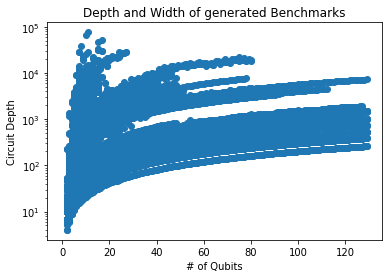

In [21]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:, 2].astype(int), y=characteristics[:, 1].astype(int))
plt.yscale("log")
plt.title("Depth and Width of generated Benchmarks")
plt.xlabel("# of Qubits")
plt.ylabel("Circuit Depth")
plt.savefig("test")